# Comparing Normalization on the ExtraSensory dataset

## Set up the Notebook

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
sys.path.insert(0, os.path.abspath('..'))
os.chdir(os.path.abspath('..'))

## Import modules

In [3]:
from Blocks.data_loader import extrasensory_data_loader
from Blocks.filter import MisingLabelFilter,  MisingDataColumnFilter, Take
from Blocks.imputer import Imputer
from Blocks.normalizer import Normalizer
from Blocks.experimental_protocol import ExpTrainTest, ExpCV, ExpWithin
from Blocks.results_analysis import ResultsConcat, ResultsCVSummarize, DataYieldReport

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.dummy import DummyClassifier

import matplotlib.pyplot as plt

from Workflow.workflow import workflow
import Workflow.compute_graph
import time
import pandas as pd


## Define the workflow

This workflow uses a basic train/test experiment to compare the use of feature normalization to  no feature normalization. The model used is logistic regression with a fixed regularization hyper-parameter. Linear models are not sensitive to feature scaling; however, when regularization is added, the regularizer is sensitive to feature scaling and different results will be obtained depending on whether and what type of normalization is applied.

The workflow includes a column filter that screens out feature dimensions that are less than 20% observed, a missing label filter that removes instances without labels, and mean imputation. Next, the workflow includes two branches, one that performs normalization, and one that does not. Each branch then executes a train/test experiment. Data loading and filtering is shared across the two branches of the workflow. The workflow computation graph is then created and displayed along with the results. 

In this experiment, we can see that the use of normalization results in almost a 15% performance improvement relative to zero imputation.

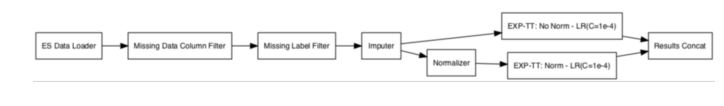

Running step ES Data Loader
  Loading Extrasensory pkl file...

Running step Missing Data Column Filter

Running step Missing Label Filter

Running step Imputer
  Imputer: Running on matrix of size 285268x224

Running step Normalizer
  Normalizer: running matrix of size 285268x224

Running step EXP-TT: Norm - LR(C=1e-4)
  Fitting and testing Norm - LR(C=1e-4)

Running step EXP-TT: No Norm - LR(C=1e-4)
  Fitting and testing No Norm - LR(C=1e-4)

Running step Results Concat
  Concatenating Results


,accuracy_score,f1_score,precision_score,recall_score
No Norm - LR(C=1e-4),0.722298,0.000000,0.000000,0.000000
Norm - LR(C=1e-4),0.862613,0.717831,0.835369,0.629289



  Workflow complete



In [4]:
metrics     = [accuracy_score, f1_score, precision_score, recall_score]

df_raw      = extrasensory_data_loader(label="SLEEPING");
df_cf       = MisingDataColumnFilter(df_raw);
df_lf       = MisingLabelFilter(df_cf);
df_imp      = Imputer(df_lf, method="mean")
df_norm     = Normalizer(df_imp)

models = {"No Norm - LR(C=1e-4)": LogisticRegression(solver="lbfgs",max_iter=100)}
res_no = ExpTrainTest(df_imp, models, metrics=metrics);

models = {"Norm - LR(C=1e-4)": LogisticRegression(solver="lbfgs",max_iter=100)}
res_yes = ExpTrainTest(df_norm, models, metrics=metrics);

res_cat = ResultsConcat(res_no, res_yes)
flow    = workflow(res_cat)
 
flow.draw(); plt.show();
output=flow.run();